<a href="https://colab.research.google.com/github/earthlovebpt/myprojects/blob/main/anime_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp /content/drive/MyDrive/projects/anime-recommedation-system/data.zip data.zip
! unzip -qq /content/data.zip

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm


from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model

# 1. EDA

In [ ]:
# Read the csv file.
df = pd.read_csv('/content/animelist.csv', nrows=5e7)
df

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4
2,0,242,10,1,4
3,0,4898,0,1,1
4,0,21,10,1,0
...,...,...,...,...,...
49999995,162169,5178,0,6,0
49999996,162169,25183,0,6,0
49999997,162169,1571,0,6,0
49999998,162169,21431,0,6,0


In [ ]:
pd.read_csv('/content/watching_status.csv')

,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


In [ ]:
df = df[df['watching_status'].isin([0,1,2,3,4,5,6])]

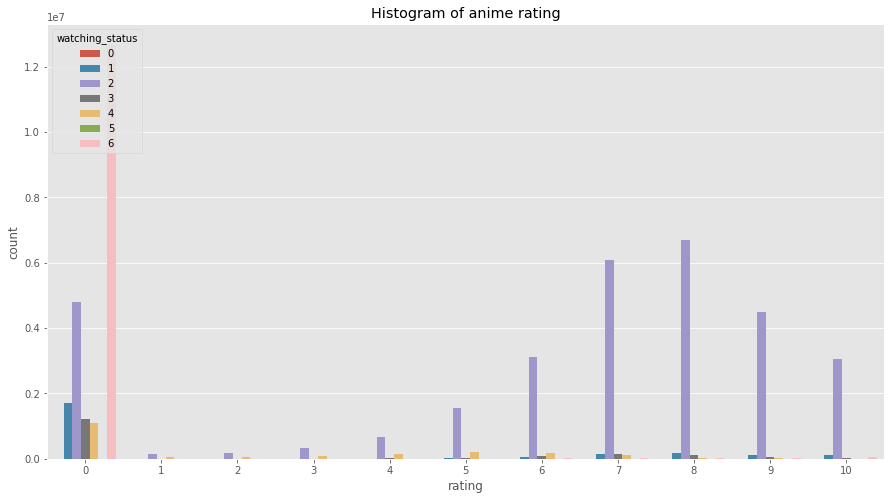

In [ ]:
# Plot the histogram.
plt.figure(figsize=(15,8))
sns.countplot(data=df, x='rating', hue='watching_status')
plt.title('Histogram of anime rating')
plt.show()

From the histogram, rating on animes cannot be used directly since the animes that are planned to watch (status=6) usually get rating 0. Consequently, we exlude the rating 0.

In [ ]:
# Exclude the plan-to-watch anime record.
df = df[df['rating']!=0]
print(f'The number of left data: {df.shape[0]}')

The number of left data: 28535793


In [ ]:
# Scale rating into range from 0 to 1.
df['scaled_rating'] = df['rating']/10
df

,user_id,anime_id,rating,watching_status,watched_episodes,scaled_rating
0,0,67,9,1,1,0.9
1,0,6702,7,1,4,0.7
2,0,242,10,1,4,1.0
4,0,21,10,1,0,1.0
5,0,24,9,1,5,0.9
...,...,...,...,...,...,...
49999955,162169,3712,6,2,12,0.6
49999956,162169,11837,7,2,13,0.7
49999957,162169,14075,6,2,24,0.6
49999959,162169,6702,6,3,102,0.6


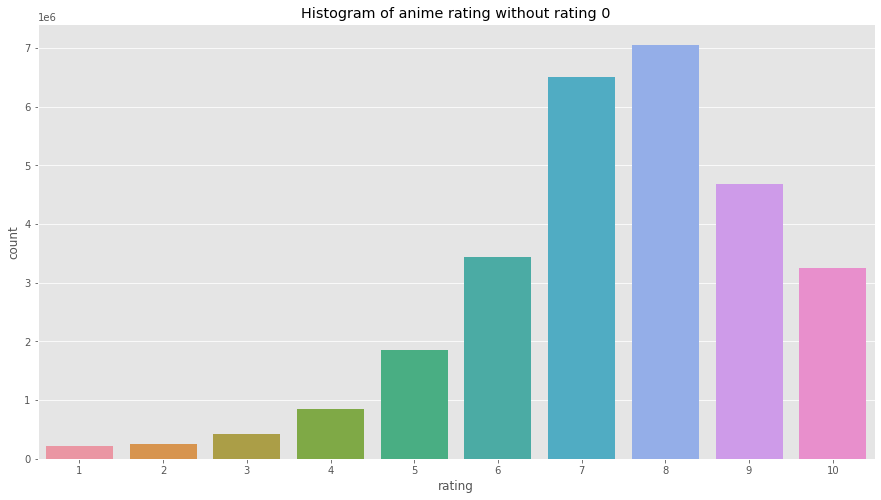

In [ ]:
# Plot the histogram.
plt.figure(figsize=(15,8))
sns.countplot(data=df, x='rating')
plt.title('Histogram of anime rating without rating 0')
plt.show()

# 2. Prepare the data

In [ ]:
# Encoding the user_id.
user_list = df["user_id"].unique().tolist()
user_encoded = {user:idx for idx,user in enumerate(user_list)}
user_decoded = {idx:user for idx,user in enumerate(user_list)}
df["user"] = df["user_id"].map(user_encoded)
n_users = len(user_encoded)

# Encoding the anime_id.
anime_list = df["anime_id"].unique().tolist()
anime_encoded = {anime:idx for idx,anime in enumerate(anime_list)}
anime_decoded = {idx:anime for idx,anime in enumerate(anime_list)}
df["anime"] = df["anime_id"].map(anime_encoded)
n_animes = len(anime_encoded)

In [ ]:
# Split data into training data(60%), evaluating data(20%), and testing data(20%).
train_df, new_df = train_test_split(df, test_size=0.4, random_state=0)
test_df, eval_df = train_test_split(new_df, test_size=0.5, random_state=0)

In [ ]:
print('The number of training data:   ',train_df.shape[0])
print('The number of evaluating data: ',eval_df.shape[0])
print('The number of testing data:    ',test_df.shape[0])

The number of training data:    17121475
The number of evaluating data:  5707159
The number of testing data:     5707159


In [ ]:
X_train = [train_df['user'].values, train_df['anime'].values]
y_train = train_df['scaled_rating'].values.reshape(-1,1)


X_eval = [eval_df['user'].values, eval_df['anime'].values]
y_eval = eval_df['scaled_rating'].values.reshape(-1,1)


X_test = [test_df['user'].values, test_df['anime'].values]
y_test = test_df['scaled_rating'].values.reshape(-1,1)

# 3. Create Model

In [ ]:
def create_model(embedding_size=128):
  user = layers.Input(name='user', shape = (1,))
  user_embedding = layers.Embedding(name='user_embedding', input_dim=n_users, output_dim=embedding_size)(user)

  anime = layers.Input(name='anime', shape = (1,))
  anime_embedding = layers.Embedding(name='anime_embedding', input_dim=n_animes, output_dim=embedding_size)(anime)


  x = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
  x = layers.Flatten()(x)
  output = layers.Dense(1, activation='sigmoid')(x)

  model = Model(inputs=[user, anime], outputs=output)
  model.compile(loss='mean_absolute_error', metrics=['mae','mse'], optimizer=optimizers.Adam(lr=0.0002))
  
  return model

In [ ]:
model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 anime (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       18417920    ['user[0][0]']                   
                                                                                                  
 anime_embedding (Embedding)    (None, 1, 128)       2169984     ['anime[0][0]']                  
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Save the best model.
checkpoint = ModelCheckpoint(filepath='best_model.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )

# Reduce lr when val_loss does not decrease.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.001
                             )

# Save log file.
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [ ]:
# Model training
hist = model.fit(
    x=X_train,
    y=y_train,
    batch_size=10000,
    epochs=20,
    verbose=1,
    validation_data=(X_eval, y_eval),
    validation_batch_size=5000,
    callbacks=callbacks
)

Epoch 1/20
1710/1713 [============================>.] - ETA: 0s - loss: 0.2097 - mae: 0.2097 - mse: 0.0615
Epoch 1: val_loss improved from inf to 0.13358, saving model to best_model.h5
1713/1713 [==============================] - 19s 10ms/step - loss: 0.2096 - mae: 0.2096 - mse: 0.0614 - val_loss: 0.1336 - val_mae: 0.1336 - val_mse: 0.0285 - lr: 2.0000e-04
Epoch 2/20
1711/1713 [============================>.] - ETA: 0s - loss: 0.1170 - mae: 0.1170 - mse: 0.0229
Epoch 2: val_loss improved from 0.13358 to 0.10655, saving model to best_model.h5
1713/1713 [==============================] - 18s 10ms/step - loss: 0.1170 - mae: 0.1170 - mse: 0.0229 - val_loss: 0.1066 - val_mae: 0.1066 - val_mse: 0.0197 - lr: 2.0000e-04
Epoch 3/20
1710/1713 [============================>.] - ETA: 0s - loss: 0.1017 - mae: 0.1017 - mse: 0.0181
Epoch 3: val_loss improved from 0.10655 to 0.10016, saving model to best_model.h5
1713/1713 [==============================] - 18s 10ms/step - loss: 0.1017 - mae: 0.1017 -

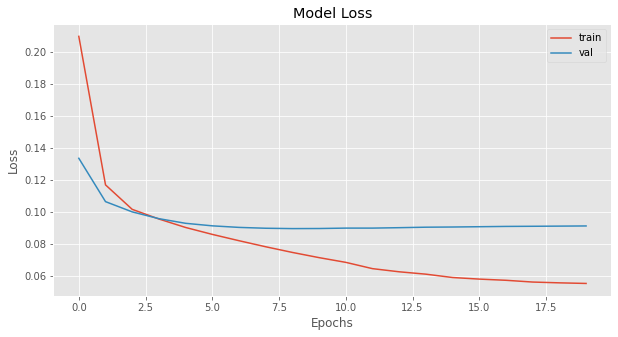

In [ ]:
def plot_history():
  plt.figure(figsize=(10,5))
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'val'])
  plt.show()

plot_history()

In [ ]:
# Evaluate the model on the test set.
best_model = load_model('/content/best_model.h5')
best_model.evaluate(X_test, y_test, batch_size=2000)

2854/2854 [==============================] - 6s 2ms/step - loss: 0.0898 - mae: 0.0898 - mse: 0.0147


[0.08976627141237259, 0.08976627141237259, 0.014703143388032913]

# 4. Recommendation system

## 4.1 Recommend similar animes

In [ ]:
# Get weights from the embedding layer.
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))  # Normalize the weights
    return weights

anime_weights = extract_weights('anime_embedding', best_model)
user_weights = extract_weights('user_embedding', best_model)

In [ ]:
synopsis = pd.read_csv('/content/anime.csv')
name_list = []

# Use English name to be shown in recommendation.
for row in synopsis[['Name', 'English name']].iterrows():
  if row[1][1] != 'Unknown':
    name_list.append(row[1][1])
  else:
    name_list.append(row[1][0])
synopsis['show_name'] = name_list 

In [ ]:
synopsis = synopsis[['MAL_ID', 'show_name','Genres']]
synopsis

,MAL_ID,show_name,Genres
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
1,5,Cowboy Bebop:The Movie,"Action, Drama, Mystery, Sci-Fi, Space"
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen"
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ..."
4,8,Beet the Vandel Buster,"Adventure, Fantasy, Shounen, Supernatural"
...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,"Adventure, Mystery, Supernatural"
17558,48483,Mieruko-chan,"Comedy, Horror, Supernatural"
17559,48488,Higurashi:When They Cry – SOTSU,"Mystery, Dementia, Horror, Psychological, Supe..."
17560,48491,Yama no Susume: Next Summit,"Adventure, Slice of Life, Comedy"


In [ ]:
print(len(anime_list))
print(len(synopsis['MAL_ID'].tolist()))

16953
17562


There are some animes not in the synopsis.

In [ ]:
pd.set_option("max_colwidth", None)

# Find the similar animes.
def find_similar_animes(anime, k=10):
    try:
      anime_id = int(synopsis[synopsis['show_name'] == anime].MAL_ID)
      anime_id_encoded = anime_encoded[anime_id]                    # Encode the anime.
      dist = np.dot(anime_weights, anime_weights[anime_id_encoded]) # Calculate the cosine similarity.
      closest = np.argpartition(dist, -(k+1))[-(k+1):]              # Sort the score.

      suggestion = []
      
      # Map to the anime name
      for idx in closest:
        score = dist[idx]
        suggestion_idx = anime_decoded[idx]
        row = synopsis[synopsis['MAL_ID'] == suggestion_idx]
        anime_name = row['show_name'].values[0]
        genre = row['Genres'].values[0]

        suggestion.append({'name':anime_name,
                          'score':score,
                          'genre':genre})

      suggestion_df = pd.DataFrame(suggestion).sort_values(by="score", ascending=False)
      return suggestion_df[suggestion_df['name']!= anime]

    except:
        print(f'{anime} is not found.')

In [ ]:
find_similar_animes('Dragon Ball Z')

,name,score,genre
10,Dragon Ball,0.888997,"Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power"
8,One Piece,0.752096,"Action, Adventure, Comedy, Super Power, Drama, Fantasy, Shounen"
9,Dragon Ball Z:Fusion Reborn,0.721909,"Action, Adventure, Comedy, Fantasy, Sci-Fi, Shounen"
6,Dragon Ball Z:Broly – The Legendary Super Saiyan,0.719839,"Action, Adventure, Comedy, Fantasy, Sci-Fi, Shounen"
4,Dragon Ball Z Kai,0.719088,"Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power"
5,Yu Yu Hakusho:Ghost Files,0.702248,"Action, Comedy, Demons, Supernatural, Martial Arts, Shounen"
3,Dragon Ball Z Special 2:The History of Trunks,0.699071,"Adventure, Drama, Fantasy, Shounen"
2,Dragon Ball Z Kai:The Final Chapters,0.682471,"Action, Adventure, Comedy, Super Power, Martial Arts, Fantasy, Shounen"
1,"Dragon Ball Z Special 1:Bardock, The Father of Goku",0.655972,"Adventure, Comedy, Fantasy, Sci-Fi, Shounen"
0,Dragon Ball Super,0.647954,"Action, Adventure, Comedy, Super Power, Martial Arts, Fantasy, Shounen"


In [ ]:
def get_fav_animes(user):
  fav_animes = df[df['user_id']==user]
  rating90 = np.percentile(fav_animes['rating'], 90)
  fav_animes = fav_animes[fav_animes['rating'] >= rating90]
  fav_anime_id = fav_animes.sort_values(by='rating', ascending=False)['anime_id'].tolist()

  fav_anime_df = synopsis[synopsis['MAL_ID'].isin(fav_anime_id)]
  return fav_anime_df

In [ ]:
get_fav_animes(1)

,MAL_ID,show_name,Genres
10,20,Naruto,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen"
176,199,Spirited Away,"Adventure, Supernatural, Drama"
1431,1575,Code Geass:Lelouch of the Rebellion,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School"
1574,1735,Naruto:Shippuden,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen"
3971,5114,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
5683,9253,Steins;Gate,"Thriller, Sci-Fi"
6565,11577,Steins;Gate:The Movie − Load Region of Déjà Vu,"Sci-Fi, Drama"
7449,16498,Attack on Titan,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen"
9383,25777,Attack on Titan Season 2,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen"
10569,30484,Steins;Gate 0,"Sci-Fi, Thriller"


In [ ]:
def recommend_similar_animes(user, k=5):
  fav_animes = get_fav_animes(user)['show_name'].values
  fav_anime_set = set(fav_animes)
  similar_animes = []
  for anime in fav_animes:
    try:
      animes =  set(find_similar_animes(anime)['name'].values) - fav_anime_set
      similar_animes += list(animes)
    except:
      continue

  suggest_names = [*pd.Series(similar_animes).value_counts().head(k).index]
  suggested_animes = synopsis[synopsis['show_name'].isin(suggest_names)]

  return suggested_animes

In [ ]:
recommend_similar_animes(1)

,MAL_ID,show_name,Genres
2656,2904,Code Geass:Lelouch of the Rebellion R2,"Action, Military, Sci-Fi, Super Power, Drama, Mecha"
3537,4181,Clannad ~After Story~,"Slice of Life, Comedy, Supernatural, Drama, Romance"
7261,15417,Gintama:Enchousen,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
8883,23273,Your Lie in April,"Drama, Music, Romance, School, Shounen"
9886,28851,A Silent Voice,"Drama, School, Shounen"


##4.2 Recommend animes which are watched by similar user.

In [ ]:
def find_similar_users(user, k=10):
    try:
      user_id_encoded = user_encoded[user]
      dist = np.dot(user_weights, user_weights[user_id_encoded])
      closest = np.argpartition(dist, -(k+1))[-(k+1):]

      suggestion = []
      for idx in closest:
        score = dist[idx]
        similar_user = user_decoded[idx]

        suggestion.append({'similar_user':similar_user,
                          'score':score})

      suggestion_df = pd.DataFrame(suggestion).sort_values(by="score", ascending=False)
      return suggestion_df[suggestion_df['similar_user']!= user]

    except:
        print(f'{user} is not found.')

In [ ]:
find_similar_users(32600)

,similar_user,score
8,45156,0.526443
9,141744,0.506963
6,117,0.491387
4,12454,0.487128
7,84069,0.472681
5,120314,0.469694
10,138292,0.453647
2,101731,0.451429
1,110124,0.448902
0,59194,0.440300


In [ ]:
def recommend_animes_by_user(user, k=5):
  fav_animes = get_fav_animes(user)['show_name'].values
  fav_anime_set = set(fav_animes)

  similar_users = find_similar_users(user)['similar_user'].values
  anime_candidates = []
  for similar_user in similar_users:
    try:
      fav_animes_of_similar_user = get_fav_animes(similar_user)['show_name'].values
      anime_candidates += list(set(fav_animes_of_similar_user) - fav_anime_set)
    except:
      continue
  
  suggest_names = [*pd.Series(anime_candidates).value_counts().head(k).index]
  suggested_animes = synopsis[synopsis['show_name'].isin(suggest_names)]

  return suggested_animes
  

In [ ]:
recommend_animes_by_user(1)

,MAL_ID,show_name,Genres
115,136,Hunter x Hunter,"Action, Adventure, Super Power, Fantasy, Shounen"
6474,11061,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
8883,23273,Your Lie in April,"Drama, Music, Romance, School, Shounen"
14306,37510,Mob Psycho 100 II,"Action, Slice of Life, Comedy, Supernatural"
14485,37779,The Promised Neverland,"Sci-Fi, Mystery, Horror, Psychological, Thriller, Shounen"
14963,38524,Attack on Titan Season 3 Part 2,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power"


## 4.3 Recommend top rating animes

In [ ]:
def recommend_top_animes(user, k=5):
  watched_anime_df = df[df.user_id==user]
  unwatched_anime_df = synopsis[~synopsis["MAL_ID"].isin(watched_anime_df['anime_id'].values)]
  unwatched_animes = list(set(unwatched_anime_df['MAL_ID']).intersection(set(anime_encoded.keys())))
  unwatched_animes = [[anime_encoded.get(x)] for x in unwatched_animes]
  
  user_id = user_encoded.get(user)
  X_array = [ np.array([user_id]*len(unwatched_animes)), np.array(unwatched_animes) ]
  ratings = model.predict(X_array).flatten()
  top_ratings_indices = (-ratings).argsort()[:k]
  recommended_anime_ids = [anime_decoded.get(unwatched_animes[x][0]) for x in top_ratings_indices]

  suggestion = []
  top_rated_ids = []
  for idx, anime_id in enumerate(unwatched_animes):
    rating = ratings[idx]
    id_ = anime_decoded.get(anime_id[0])
    
    if id_ in recommended_anime_ids:
        top_rated_ids.append(id_)
        try:
            row = synopsis[synopsis['MAL_ID'] == id_]
            anime_name = row['show_name'].values[0]
            genre = row['Genres'].values[0]
            suggestion.append({'name':anime_name,
                              'pred_rating':rating,
                              'genre':genre})
        except:
            continue
            
  suggestion_df = pd.DataFrame(suggestion).sort_values(by="pred_rating", ascending=False)
  return suggestion_df

In [ ]:
recommend_top_animes(1)

,name,pred_rating,genre
1,Gintama: The Final,0.980847,"Action, Sci-Fi, Comedy, Historical, Parody, Drama, Samurai, Shounen"
3,"Maou Gakuin no Futekigousha: Shijou Saikyou no Maou no Shiso, Tensei shite Shison-tachi no Gakkou e",0.965877,"Action, Demons, Magic, Fantasy, School"
4,Gintama Season 4,0.957808,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
2,"Maou Gakuin no Futekigousha: Shijou Saikyou no Maou no Shiso, Tensei shite Shison-tachi no Gakkou e",0.955009,"Magic, Fantasy, School"
0,Sensou: Kodomo-tachi no Yuigon,0.952838,"Drama, Historical"
